<a href="https://colab.research.google.com/github/mifm/examples/blob/master/Turbine_selection_HD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git to /tmp/pip-req-build-o6u4w3zj
  Running command git clone -q https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git /tmp/pip-req-build-o6u4w3zj
  Created wheel for py-wake: filename=py_wake-2.3.0-py3-none-any.whl size=24796560 sha256=d1c1f11b2e70ca629e5717b2b4875f344ff27f17bfdc1157430d9b940d07f483
  Stored in directory: /tmp/pip-ephem-wheel-cache-8fntkt5h/wheels/fb/b1/5a/9b9114aac7776bf9de40facb8a0f958449e0a2082c955ca29e
Successfully built py-wake


In [2]:
from py_wake.wind_farm_models import PropagateDownwind
from abc import abstractmethod, ABC
from py_wake.site._site import Site, UniformSite, LocalWind
from py_wake.wind_turbines import WindTurbines
from py_wake import np
from py_wake.flow_map import FlowMap, HorizontalGrid, FlowBox, Grid
import xarray as xr
from py_wake.utils import xarray_utils, weibull  # register ilk function @UnusedImport
from numpy import newaxis as na
from py_wake.utils.model_utils import check_model, fix_shape
import multiprocessing
from py_wake.utils.parallelization import get_pool
from py_wake.wind_turbines import WindTurbines
from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtFunctionList

from py_wake.utils.functions import mean_deg, arg2ilk

class PowerCtFunctionEta(PowerCtFunctionList):
    def __init__(self, key, powerCtFunction_lst, default_value=None, additional_models=[]):
        self.n_types = len(powerCtFunction_lst)
        self._keys = [f'{key}_{i}' for i in range(self.n_types)]
        PowerCtFunctionList.__init__(self, key=key, powerCtFunction_lst=powerCtFunction_lst, 
                             default_value=default_value, additional_models=additional_models)
        required_inputs = list(self._required_inputs) 
        required_inputs.remove(key)
        self._required_inputs = set(required_inputs + self._keys)

    def __call__(self, ws, run_only=slice(None), **kwargs):
        etas_e = np.array([kwargs[k] for k in self._keys])

        for k in self._keys:
            kwargs.pop(k)
            
        def get_kwargs(idx):
            return {k: v for k, v in kwargs.items() if k in self.windTurbineFunction_lst[idx].inputs}
        
        val = np.stack([wt_func(ws, run_only=run_only, **get_kwargs(idx)) 
                        for idx, wt_func in enumerate(self.windTurbineFunction_lst)])
        
        
        etas_sum = etas_e.sum() + 1.E-12
        #Pct = (etas_e[:,na] * val).sum(0)/etas_sum   
        
        if len(val.shape)==5:
            Pct = (etas_e[:, na, :, na, na] * val).sum(0)/etas_sum
        elif len(val.shape)==4:
            Pct = (etas_e[:, :, na, na] * val).sum(0)/etas_sum
        elif len(val.shape)==3:
            Pct = (etas_e[:, :, na] * val).sum(0)/etas_sum        
        elif len(val.shape)==2:
            if val.shape[0]>2:
                Pct = (etas_e[:,:,na] * val[:,na,:]).sum(0)/etas_sum        
            else:
                Pct = (etas_e * val).sum(0)/etas_sum        
        elif len(val.shape)==1:
            Pct = (etas_e * val).sum()/etas_sum                
        return Pct

class EtaTurbines(WindTurbines):
    def __init__(self, names, diameters, hub_heights, powerCtFunctions, loadFunctions=None, key='eta'):
        """Initialize WindTurbines

        Parameters
        ----------
        names : array_like
            Wind turbine names
        diameters : array_like
            Diameter of wind turbines
        hub_heights : array_like
            Hub height of wind turbines
        powerCtFunctions : list of powerCtFunction objects
            Wind turbine ct functions; func(ws) -> ct
        """
        self.key = key
        self.n_types = len(powerCtFunctions)
        self._keys = [f'{key}_{i}' for i in range(self.n_types)]        
        self._names = np.array(names)
        self._diameters = np.array(diameters)
        self._hub_heights = np.array(hub_heights)
        assert len(names) == len(diameters) == len(hub_heights) == len(powerCtFunctions)
        self.powerCtFunction = PowerCtFunctionEta(self.key, powerCtFunctions)
        
    def get_defaults(self, N, type_i=0, h_i=None, d_i=None, **kwargs):
        """
        Parameters
        ----------
        N : int
            number of turbines
        type_i : array_like or None, optional
            Turbine type. If None, all turbines is type 0
        h_i : array_like or None, optional
            hub heights. If None: default hub heights (set in WindTurbines)
        d_i : array_lie or None, optional
            Rotor diameter. If None: default diameter (set in WindTurbines)
        """
        if self._keys[0] in kwargs:
            eta_ie = np.array([kwargs[k] for k in self._keys])
        else:
            return WindTurbines.get_defaults(self, N, type_i=type_i, h_i=h_i, d_i=d_i)
        
        if h_i is None:
            h_i = ((eta_ie[:, :] * self._hub_heights[:, na]).sum(0) / 
                (eta_ie+1.E-12).sum(0))
        elif isinstance(h_i, (int, float)):
            h_i = np.zeros(N) + h_i
        if d_i is None:
            d_i = ((eta_ie[:, :] * self._diameters[:, na]).sum(0) / 
                (eta_ie+1.E-12).sum(0))
        elif isinstance(d_i, (int, float)):
            d_i = np.zeros(N) + d_i
        return np.asarray(h_i), np.asarray(d_i) + 1.E-12
    
    @staticmethod
    def from_WindTurbine_lst(wt_lst):
        """Generate a WindTurbines object from a list of (Onetype)WindTurbines

        Parameters
        ----------
        wt_lst : array_like
            list of (OneType)WindTurbines
        """
        def get(att):
            lst = []
            for wt in wt_lst:
                lst.extend(getattr(wt, att))
            return lst
        return EtaTurbines(*[get(n) for n in ['_names', '_diameters', '_hub_heights']] +
                            [[getattr(wt, 'powerCtFunction') for wt in wt_lst]])
        

class MyPropagateDownwind(PropagateDownwind):
    def aep(self, x, y, h=None, d=None, type=0, wd=None, ws=None, yaw=None, tilt=None,  
            normalize_probabilities=False, with_wake_loss=True,
            n_cpu=1, wd_chunks=None, ws_chunks=None, **kwargs):
        """Anual Energy Production (sum of all wind turbines, directions and speeds) in GWh.

        the typical use is:
        >> sim_res = windFarmModel(x,y,...)
        >> sim_res.aep()

        This function bypasses the simulation result and returns only the total AEP,
        which makes it slightly faster for small problems.
        >> windFarmModel.aep(x,y,...)

        Parameters
        ----------
        x : array_like
            Wind turbine x positions
        y : array_like
            Wind turbine y positions
        h : array_like, optional
            Wind turbine hub heights
        type : int or array_like, optional
            Wind turbine type, default is 0
        wd : int or array_like
            Wind direction(s)
        ws : int, float or array_like
            Wind speed(s)
        yaw : int, float, array_like or None, optional
            Yaw misalignement, Positive is counter-clockwise when seen from above.
            May be
            - constant for all wt and flow cases or dependent on
            - wind turbine(i),
            - wind turbine and wind direction(il) or
            - wind turbine, wind direction and wind speed (ilk)
        tilt : array_like or None, optional
            Tilt angle of rotor shaft. Normal tilt (rotor center above tower top) is positivie
            May be
            - constant for all wt and flow cases or dependent on
            - wind turbine(i),
            - wind turbine and wind direction(il) or
            - wind turbine, wind direction and wind speed (ilk)
        n_cpu : int or None, optional
            Number of CPUs to be used for execution.
            If 1 (default), the execution is not parallized
            If None, the available number of CPUs are used
        wd_chunks : int or None, optional
            If n_cpu>1, the wind directions are divided into <wd_chunks> chunks and executed in parallel.
            If wd_chunks is None, wd_chunks is set to the available number of CPUs
        ws_chunks : int or None, optional
            If n_cpu>1, the wind speeds are divided into <ws_chunks> chunks and executed in parallel.
            If ws_chunks is None, ws_chunks is set to 1

        Returns
        -------
        AEP in GWh

        """
        if n_cpu != 1 or wd_chunks or ws_chunks:
            return self._aep_chunk_wrapper(
                self._aep_kwargs,
                x, y, h, type, wd, ws, yaw, tilt,
                normalize_probabilities=False, with_wake_loss=True,
                n_cpu=1, wd_chunks=None, ws_chunks=None, **kwargs)
        wd, ws = self.site.get_defaults(wd, ws)
        I, L, K, = len(x), len(np.atleast_1d(wd)), len(np.atleast_1d(ws))
        yaw_ilk = fix_shape(yaw, (I, L, K), allow_None=True, allow_number=True)
        tilt_ilk = fix_shape(tilt, (I, L, K), allow_None=True, allow_number=True)

        _, _, power_ilk, _, localWind, power_ct_inputs = self.calc_wt_interaction(
            x_i=x, y_i=y, h_i=h, d_i=d, type_i=type, yaw_ilk=yaw_ilk, tilt_ilk=tilt_ilk, wd=wd, ws=ws, **kwargs)
        P_ilk = localWind.P_ilk
        if normalize_probabilities:
            norm = P_ilk.sum((1, 2))[:, na, na]
        else:
            norm = 1

        if with_wake_loss is False:
            power_ilk = self.windTurbines.power(localWind.WS_ilk, **power_ct_inputs)
        return (power_ilk * P_ilk / norm * 24 * 365 * 1e-9).sum()

    def calc_wt_interaction(self, x_i, y_i, h_i=None, d_i=None, type_i=0, wd=None, ws=None, time=False,
                            yaw_ilk=None, tilt_ilk=None,
                            n_cpu=1, wd_chunks=None, ws_chunks=1,
                            **kwargs):
        """See WindFarmModel.calc_wt_interaction and additional parameters below

        Parameters
        ----------
        n_cpu : int or None, optional
            Number of CPUs to be used for execution.
            If 1 (default), the execution is not parallized
            If None, the available number of CPUs are used
        wd_chunks : int or None, optional
            If n_cpu>1, the wind directions are divided into <wd_chunks> chunks and executed in parallel.
            If wd_chunks is None, wd_chunks is set to the available number of CPUs
        ws_chunks : int or None, optional
            If n_cpu>1, the wind speeds are divided into <ws_chunks> chunks and executed in parallel.
            If ws_chunks is None, ws_chunks is set to 1
        """
        h_i, D_i = self.windTurbines.get_defaults(len(x_i), type_i, h_i, d_i, **kwargs)
        x_i, y_i, type_i = [np.asarray(v) for v in [x_i, y_i, type_i]]
        wd, ws = self.site.get_defaults(wd, ws)

        # Find local wind speed, wind direction, turbulence intensity and probability
        lw = self.site.local_wind(x_i=x_i, y_i=y_i, h_i=h_i, wd=wd, ws=ws, time=time)
        I, L, K, = len(x_i), len(wd), (1, len(ws))[time is False]

        wt_kwargs = kwargs
        ri, oi = self.windTurbines.function_inputs
        unused_inputs = set(wt_kwargs) - set(ri) - set(oi) - {'WS', 'WD', 'TI'}
        if unused_inputs:
            raise TypeError("""got unexpected keyword argument(s): '%s'
            required arguments: %s
            optional arguments: %s""" % ("', '".join(unused_inputs), ['ws'] + ri, oi))

        wt_kwargs = {k: arg2ilk(k, v, I, L, K) for k, v in wt_kwargs.items()}

        if n_cpu != 1 or wd_chunks or ws_chunks > 1:
            # parallel execution
            map_func, arg_lst, wd_chunks, ws_chunks = self._multiprocessing_chunks(
                wd=wd, ws=ws, time=time, n_cpu=n_cpu, wd_chunks=wd_chunks, ws_chunks=ws_chunks,
                x_i=x_i, y_i=y_i, h_i=h_i, type_i=type_i, yaw_ilk=yaw_ilk, tilt_ilk=tilt_ilk, **kwargs)

            WS_eff_ilk, TI_eff_ilk, power_ilk, ct_ilk, _, wt_inputs = list(
                zip(*map_func(self._calc_wt_interaction_args, arg_lst)))

            def concatenate(v_ilk):
                if all([v is None for v in v_ilk]):
                    return None
                if time is False:
                    v_ilk = [np.broadcast_to(v, WS_eff.shape) for v, WS_eff in zip(v_ilk, WS_eff_ilk)]

                    return np.concatenate([np.concatenate(v_ilk[i::ws_chunks], axis=1)
                                           for i in range(ws_chunks)], axis=2)
                else:
                    v_ilk = [np.broadcast_to(v, WS_eff.shape) for v, WS_eff in zip(v_ilk, WS_eff_ilk)]
                    return np.concatenate(v_ilk, axis=1)

            return ([concatenate(v) for v in [WS_eff_ilk, TI_eff_ilk, power_ilk, ct_ilk]] +
                    [lw, {k: concatenate([wt_i[k] for wt_i in wt_inputs]) for k in wt_inputs[0]}])

        # Calculate down-wind and cross-wind distances
        self._validate_input(x_i, y_i)

        for k in ['WS', 'WD', 'TI']:
            if k in kwargs:
                lw.add_ilk(k + '_ilk', kwargs[k])

        self.site.distance.setup(x_i, y_i, h_i)

        def add_arg(name, optional):
            if name in wt_kwargs:  # custom WindFarmModel.__call__ arguments
                return
            elif name in {'yaw', 'tilt', 'type'}:  # fixed WindFarmModel.__call__ arguments
                wt_kwargs[name] = {'yaw': yaw_ilk, 'tilt': tilt_ilk, 'type': type_i}[name]
            elif name + '_ilk' in lw:
                wt_kwargs[name] = lw[name + '_ilk']
            elif name in self.site.ds:
                wt_kwargs[name] = self.site.interp(self.site.ds[name], lw)
            elif name in ['TI_eff']:
                if self.turbulenceModel:
                    wt_kwargs['TI_eff'] = None
                elif optional is False:
                    raise KeyError("Argument, TI_eff, needed to calculate power and ct requires a TurbulenceModel")
            elif name in ['dw_ijl', 'cw_ijl', 'hcw_ijl']:
                pass
            elif optional:
                pass
            else:
                raise KeyError("Argument, %s, required to calculate power and ct not found" % name)
        for opt, lst in zip([False, True], self.windTurbines.function_inputs):
            for k in lst:
                add_arg(k, opt)

        if yaw_ilk is None:
            yaw_ilk = np.zeros((I, L, K))
        if tilt_ilk is None:
            tilt_ilk = np.zeros((I, L, K))

        kwargs = {'wd': lw.wd,
                  'WD_ilk': lw.WD_ilk,
                  'WS_ilk': lw.WS_ilk,
                  'TI_ilk': lw.TI_ilk,
                  'WS_eff_ilk': lw.WS_ilk + 0.,  # autograd-friendly copy
                  'TI_eff_ilk': lw.TI_ilk + 0.,
                  'x_i': x_i, 'y_i': y_i, 'h_i': h_i, 'D_i': D_i,
                  'yaw_ilk': yaw_ilk, 'tilt_ilk': tilt_ilk,
                  'I': I, 'L': L, 'K': K, **wt_kwargs}
        WS_eff_ilk, TI_eff_ilk, ct_ilk = self._calc_wt_interaction(**kwargs)
        if 'TI_eff' in wt_kwargs:
            wt_kwargs['TI_eff'] = TI_eff_ilk
        d_ijl_keys = ({k for l in self.windTurbines.function_inputs for k in l} &
                      {'dw_ijl', 'hcw_ijl', 'dh_ijl', 'cw_ijl'})
        if d_ijl_keys:
            d_ijl_dict = {k: lambda v=v: v for k, v in zip(['dw_ijl', 'hcw_ijl', 'dh_ijl'], self.site.distance(wd[na]))}
            d_ijl_dict['cw_ijl'] = lambda d_ijl_dict=d_ijl_dict: np.sqrt(
                d_ijl_dict['dw_ijl']**2 + d_ijl_dict['hcw_ijl']**2)
            wt_kwargs.update({k: d_ijl_dict[k]() for k in d_ijl_keys})

        wt_kwargs_keys = set(self.windTurbines.powerCtFunction.required_inputs +
                             self.windTurbines.powerCtFunction.optional_inputs)
        power_ilk = self.windTurbines.power(WS_eff_ilk, **{k: v for k, v in wt_kwargs.items() if k in wt_kwargs_keys})

        return WS_eff_ilk, TI_eff_ilk, power_ilk, ct_ilk, lw, wt_kwargs


    

In [3]:
import autograd.numpy as np
import matplotlib.pyplot as plt
from py_wake.wind_turbines._wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtFunction
from py_wake.utils.model_utils import fix_shape
import seaborn as sns
import multiprocessing
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from py_wake.site import UniformSite
from py_wake.utils.gradients import autograd
from scipy.optimize import basinhopping
import scipy as sp
from scipy.optimize import minimize
import os, time

# Adding D_is to the mix

We need to expose d_i to calc_wt_interaction

In [6]:
from py_wake.wind_turbines import WindTurbines

In [7]:
from py_wake.utils import gradients
from py_wake.utils.gradients import PchipInterpolator, UnivariateSpline, set_gradient_function

In [8]:
from py_wake.examples.data.hornsrev1 import Hornsrev1Site # We work with the Horns Rev 1 site, which comes already set up with PyWake.
from py_wake.examples.data.hornsrev1 import wt_x, wt_y # The existing layout coordinates are also available from PyWake

Script to generate turbines with different D and H and fixed power rating wind turbines

In [9]:
from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine
from numpy import newaxis as na
def gen_wt(D, H):
    return GenericWindTurbine(f'2MW_{D}_{H}', D, H, power_norm=2000)


Generating some turbine types

In [10]:
DH_array = np.array([
    # D    H 
    (80., 70),  #0
    (80, 100),  #1
    (80, 130),  #2
    (100, 100), #3
    (100, 130), #4
    (130, 100), #5
    (130, 130), #6
      ])
n_eta = DH_array.shape[0]
# Create a list of wind turbines
wind_turbines = [gen_wt(D, H) for (D,H) in DH_array]
rand_eta = lambda : np.random.rand(n_eta)
f_eta = lambda etas_e: {f'eta_{i}':v for i, v in zip(range(n_eta), etas_e)}
drand_eta = lambda : f_eta(rand_eta())

We create a new type of turbine that is a composite of a list of wind turbines

In [11]:
eta_wts = EtaTurbines.from_WindTurbine_lst(wind_turbines)

Testing that it works

In [12]:
DH_array[:,0]

array([ 80.,  80.,  80., 100., 100., 130., 130.])

In [13]:
n_wt = 2
etas = np.random.rand(n_eta*n_wt).reshape([n_eta, n_wt])
etas = np.zeros([n_eta, n_wt])
etas[0,0] = 1.
etas[4,1] = 1.
print(etas)
D = (etas[:,:] * DH_array[:,na,0]).sum(0)/etas.sum(0)
H = (etas[:,:] * DH_array[:,na,1]).sum(0)/etas.sum(0)
print(H,D)

[[1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]]
[ 70. 130.] [ 80. 100.]


In [14]:

d_etas = f_eta(etas.reshape([n_eta, n_wt])) 
print(d_etas)
H, D = eta_wts.get_defaults(n_wt, **d_etas)
print(H,D)

{'eta_0': array([1., 0.]), 'eta_1': array([0., 0.]), 'eta_2': array([0., 0.]), 'eta_3': array([0., 0.]), 'eta_4': array([0., 1.]), 'eta_5': array([0., 0.]), 'eta_6': array([0., 0.])}
[ 70. 130.] [ 80. 100.]


In [15]:
wt0 = wind_turbines[0]
wt0.power_ct(4)

[73441.2328462889, 0.8000006172162063]

In [16]:
wt0.powerCtFunction

Let's look at a few wind turbines

Power curve

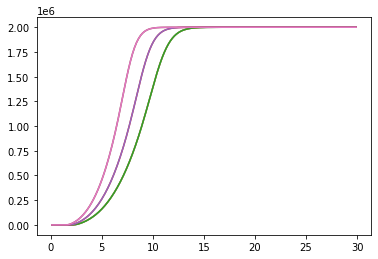

In [17]:
for wt in wind_turbines:
    plt.plot(wt.powerCtFunction.ws_tab, wt.powerCtFunction.power_ct_tab[0,:])

CT Curves

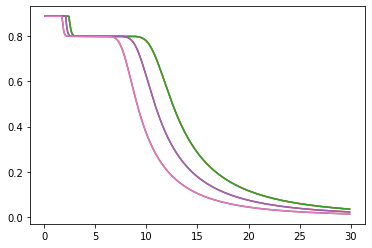

In [18]:
for wt in wind_turbines:
    plt.plot(wt.powerCtFunction.ws_tab, wt.powerCtFunction.power_ct_tab[1,:])

### Wind turbine setup

This wind turbine has a special input that takes n_eta additioanl inputs

In [19]:
eta_wts.powerCtFunction._required_inputs

{'eta_0', 'eta_1', 'eta_2', 'eta_3', 'eta_4', 'eta_5', 'eta_6'}

In [20]:
n_wt = 2
d_eta_dict = f_eta(np.random.rand(n_wt * n_eta).reshape([n_eta, n_wt]))
d_eta_dict

{'eta_0': array([0.06184962, 0.779465  ]),
 'eta_1': array([0.4735493 , 0.50761706]),
 'eta_2': array([0.37675349, 0.56128913]),
 'eta_3': array([0.99339933, 0.79913741]),
 'eta_4': array([0.5680699, 0.2988389]),
 'eta_5': array([0.60163149, 0.76269553]),
 'eta_6': array([0.63700264, 0.64670456])}

In [21]:
eta_wts.powerCtFunction(8., eta_0=d_eta_dict['eta_0'], 
                            eta_1=d_eta_dict['eta_1'], 
                            eta_2=d_eta_dict['eta_2'], 
                            eta_3=d_eta_dict['eta_3'], 
                            eta_4=d_eta_dict['eta_4'], 
                            eta_5=d_eta_dict['eta_5'], 
                            eta_6=d_eta_dict['eta_6'])

array([[5.66163852e+05, 3.50631482e-01],
       [6.21265802e+05, 4.12268454e-01]])

In [22]:
eta_wts.powerCtFunction(8., **d_eta_dict)

array([[5.66163852e+05, 3.50631482e-01],
       [6.21265802e+05, 4.12268454e-01]])

In [23]:
n_wt = 2
d_eta_dict = f_eta(np.random.rand(n_wt * n_eta).reshape([n_eta, n_wt]))
print(d_eta_dict)
H, D = eta_wts.get_defaults(n_wt, **d_eta_dict)
print(D)
print(H)

{'eta_0': array([0.83540777, 0.11496684]), 'eta_1': array([0.92883654, 0.07604098]), 'eta_2': array([0.00860688, 0.36506781]), 'eta_3': array([0.30006923, 0.56526334]), 'eta_4': array([0.01747917, 0.15878484]), 'eta_5': array([0.81732046, 0.81338932]), 'eta_6': array([0.46746759, 0.21584217])}
[100.91450255 108.55452257]
[ 96.96146553 108.1156154 ]


### Wind Farm setup 

In [24]:
from py_wake.deficit_models import NOJDeficit
from py_wake.superposition_models import SquaredSum

In [25]:
site = Hornsrev1Site()
wfm = MyPropagateDownwind(site, eta_wts, wake_deficitModel=NOJDeficit(), superpositionModel=SquaredSum())

In [26]:
wfm.aep(np.array(wt_x)[:n_wt], np.array(wt_y)[:n_wt], **d_eta_dict)

154.72901145954603

In [27]:
n_wt = 10
x, y = np.array(wt_x)[:n_wt], np.array(wt_y)[:n_wt]

n_eta = DH_array.shape[0]
n_ds = n_wt * n_eta
lamb1 = 1.E1
lamb2 = 1.E1
ref_aep = 1.1 * 1E1

q = 6

def constraint(eta_array):
    return (lamb1 * np.sum((1-eta_array.sum(0))**2.0)**2. + 
            lamb2 * np.sum((eta_array*(1-eta_array))**2.))

def ramp(eta):
    """DOI:10.48550/arXiv.2203.13525 - Eq.18"""
    return eta / (1 + q*(1-eta))

def compute_DH(eta_array):
    return ((eta_array[:, :, na] * DH_array[:, na, :]).sum(0) / 
            (eta_array+1.E-12).sum(0)[:, na]).T

def compute_aep(eta_array):
    #, wd=np.linspace(0, 360, 12, endpoint=False)
    return  wfm.aep(x, y, n_cpu=1, **f_eta(eta_array)).sum()

def my_obj_func(eta_vec):
    #Adding the ramp
    eta_vec = ramp(eta_vec)
    eta_array = eta_vec.reshape([n_eta, n_wt])
    #D, H = compute_DH(eta_array)
    #D = D + 1.E-12
    #H = H + 1.E-12
    aep = compute_aep(eta_array)
    penality = constraint(eta_array)
    return penality - aep / ref_aep


aep_grad = autograd(my_obj_func)

In [28]:
def process_results(x):
    x = ramp(x)
    eta_array = x.reshape([n_eta, n_wt])
    if constraint(eta_array)>1E-3:
        print('constraint not fullfilled', constraint(eta_array))
    else:
        print('constraint fullfilled', constraint(eta_array))
    print('eta.sum(0)', eta_array.sum(0))
    D, H = ((eta_array[:, :, na] * DH_array[:, na, :]).sum(0) / (eta_array).sum(0)[:, na]).T
    print('D', D)
    print('H', H)
    aep = compute_aep(eta_array)
    print('aep', aep)
    return aep
    

Testing with a valid turbine

In [29]:
eta_array = np.zeros([n_eta, n_wt])
eta_array[1,:] = 1.0

In [30]:
eta_array

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [31]:
f_eta(eta_array)

{'eta_0': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'eta_1': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'eta_2': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'eta_3': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'eta_4': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'eta_5': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'eta_6': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [32]:
my_obj_func(eta_array.flatten())

-70.33035934750079

In [33]:
process_results(eta_array)

constraint fullfilled 0.0
eta.sum(0) [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
D [80. 80. 80. 80. 80. 80. 80. 80. 80. 80.]
H [100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
aep 773.6339528225087


773.6339528225087

In [34]:
wfm.aep(x, y, n_cpu=1, **f_eta(eta_array))

773.6339528225087

In [35]:
wfm.windTurbines.get_defaults(n_wt, **f_eta(eta_array))

(array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100.]),
 array([80., 80., 80., 80., 80., 80., 80., 80., 80., 80.]))

In [36]:
def opti_DH(method='SLSQP', x0=None, niter=10, strategy='minimize'):
    """
    Parameters:
    -----------
    method: str [default='SLSQP'] {'L-BFGS-B','trust-constr','TNC', 'SLSQP'}
    x0: np.array
        initial design variable. If left None it will randomly pick one.
    niter: int
        max number of iteration
    strategy: str ['default'='minimize'] {'minimize', 'basinhopping'}
    
    returns: tuple
        - scipy minimize result dictionary
        - aep
    
    """
    np.random.seed((os.getpid() * int(time.time())) % 123456789) # random the seed
    if x0 is None:
        x0 = np.random.rand(n_ds)
        
    bounds = np.stack([np.zeros(n_ds), np.ones(n_ds)]).T
    if strategy=='minimize':
        res = minimize(my_obj_func, x0, jac=aep_grad, bounds=bounds, method=method, 
                       options={'maxiter':niter})
    if strategy=='basinhopping':
        res = basinhopping(my_obj_func, x0, 
                           minimizer_kwargs={'method':method, 'jac':aep_grad, 'bounds':bounds}, 
                           niter=niter)
    print(res)
    return res, process_results(res['x'])

In [37]:
save_aep = {}
save_res = {}

In [38]:
method = 'SLSQP'# {'trust-constr' | 'TNC' | 'SLSQP' | 'L-BFGS-B'}
x0 = None #x0=save_res['L-BFGS-B']['x']
strategy='minimize' # {'minimize' | 'basinhopping'}
res, aep = opti_DH(method=method, x0=x0, niter=1000, strategy=strategy)
save_res[f'{strategy}_{method}'], save_aep[f'{strategy}_{method}'] = res, aep

     fun: -67.21241728975085
     jac: array([-5.39376740e-04, -5.89411220e-06, -3.39954930e-03, -2.86278005e-04,
        1.53309191e-04,  4.02070018e-04,  6.14829357e-04,  2.59940533e-04,
        1.71137791e-04, -1.77924082e-05, -1.15081289e-03, -1.25708099e-05,
        1.13770424e-04,  2.34880658e-04,  1.12539952e-04,  1.58123036e-05,
        5.14681715e-04,  2.60396208e-04,  1.13605258e-04, -2.30579562e-05,
       -5.57813777e-04, -1.92475076e-05,  1.24312262e-04, -1.91419185e-04,
        3.79040775e-03,  7.78164972e-05,  2.60749746e-04,  3.56070435e-04,
        1.12809181e-04, -2.83235041e-05, -1.70659522e-03, -4.22901179e-06,
        1.48773613e-04, -2.20712650e-04,  1.17863097e-04,  2.12810393e-05,
        4.64769740e-04,  1.21764442e-03,  1.56039882e-04, -1.66858120e-05,
       -6.22732254e-04, -1.09057095e-05,  2.10984605e-04,  2.32673661e-04,
        1.70053800e-04,  3.15724212e-05,  4.26215722e-04,  2.64490396e-04,
        6.09308160e-04, -2.19513600e-05, -2.38012672e-04,  3.

In [39]:
save_aep

{'minimize_SLSQP': 773.6290860729603}

In [40]:
save_res

{'minimize_SLSQP':      fun: -67.21241728975085
     jac: array([-5.39376740e-04, -5.89411220e-06, -3.39954930e-03, -2.86278005e-04,
        1.53309191e-04,  4.02070018e-04,  6.14829357e-04,  2.59940533e-04,
        1.71137791e-04, -1.77924082e-05, -1.15081289e-03, -1.25708099e-05,
        1.13770424e-04,  2.34880658e-04,  1.12539952e-04,  1.58123036e-05,
        5.14681715e-04,  2.60396208e-04,  1.13605258e-04, -2.30579562e-05,
       -5.57813777e-04, -1.92475076e-05,  1.24312262e-04, -1.91419185e-04,
        3.79040775e-03,  7.78164972e-05,  2.60749746e-04,  3.56070435e-04,
        1.12809181e-04, -2.83235041e-05, -1.70659522e-03, -4.22901179e-06,
        1.48773613e-04, -2.20712650e-04,  1.17863097e-04,  2.12810393e-05,
        4.64769740e-04,  1.21764442e-03,  1.56039882e-04, -1.66858120e-05,
       -6.22732254e-04, -1.09057095e-05,  2.10984605e-04,  2.32673661e-04,
        1.70053800e-04,  3.15724212e-05,  4.26215722e-04,  2.64490396e-04,
        6.09308160e-04, -2.19513600e-05, -

In [42]:
a_pool = multiprocessing.get_context('fork').Pool()
bounds = np.stack([np.zeros(n_ds), np.ones(n_ds)]).T
res = basinhopping(my_obj_func, res['x'], minimizer_kwargs={'method':'L-BFGS-B', 'jac':aep_grad, 'bounds':bounds}, niter=100)
print(res)
basinhopping_aep = process_results(res['x'])

Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 216, i

KeyboardInterrupt: ignored

  File "/usr/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [ ]:
#methods = ['dogleg', 'trust-constr', 'TNC', 'SLSQP', 'L-BFGS-B']
methods = ['TNC', 'SLSQP', 'L-BFGS-B']


results = a_pool.map(opti_DH, methods)


In [ ]:
res = basinhopping(my_obj_func, x0, minimizer_kwargs={'method':'TNC', 'jac':aep_grad, 'bounds':bounds}, niter=100)
print(res)
basinhopping_aep = process_results(res['x'])

In [ ]:
BFGS_aep = process_results(res['x'])

In [ ]:
res

In [ ]:
x_end = ramp(res['x'])

In [ ]:
eta_array = x_end.reshape([n_eta, n_wt])

In [ ]:
eta_array.shape

In [ ]:
eta_array[:,0]

In [ ]:
constraint(eta_array)

In [ ]:
eta_array.sum(0)

In [ ]:
np.sum((1-eta_array.sum(0))**2.0)

In [ ]:
eta_array.sum(0).shape

In [ ]:
D, H = ((eta_array[:, :, na] * DH_array[:, na, :]).sum(0) / (eta_array).sum(0)[:, na]).T



In [ ]:
D

In [ ]:
H

In [ ]:
compute_aep(D, H, eta_array)

In [ ]:
DH_array

In [ ]:
eta_array.shape

### Alternative method

In [ ]:
PCT_func = lambda ws: np.array([[gradients.interp(ws, wt.powerCtFunction.ws_tab, wt.powerCtFunction.power_ct_tab[0,:]),
                                 gradients.interp(ws, wt.powerCtFunction.ws_tab, wt.powerCtFunction.power_ct_tab[1,:])]
                                   for wt in wind_turbines])

In [ ]:
def eta_power_ct(u, run_only, **kwargs):
    """
    etas: vector of eta for one turbine
    """
    etas_e = np.array([kwargs[f'eta_{i}'] for i in range(n_eta)])
    PCT = PCT_func(u)
    etas_sum = etas_e.sum() + 1.E-12
    if len(PCT.shape)==5:
        Pct = (etas_e[:, na, :, na, na] * PCT).sum(0)/etas_sum
    elif len(PCT.shape)==4:
        Pct = (etas_e[:, na, :, na] * PCT).sum(0)/etas_sum
    elif len(PCT.shape)==3:
        Pct = (etas_e[:, :, na] * PCT).sum(0)/etas_sum        
    elif len(PCT.shape)==2:
        Pct = (etas_e[:, na] * PCT).sum(0)/etas_sum        
    return Pct[run_only]


powerCtFunction = PowerCtFunction(
    input_keys=['ws']+[f'eta_{i}' for i in range(n_eta)],
    power_ct_func=eta_power_ct,
    power_unit='w',
)